<h1><center>DSA 4212: Year 2022</center></h1>
<h3><center> Assignment 2 Question 2  </center></h3>
<h4><center> Group Number: 9 </center></h4>
<h4><center> Group Member 1: Lee Wei Qing, A0205666B </center></h4>
<h4><center> Group Member 2: Madeline Lim Chia Bing, A0205053W </center></h4>
<h4><center> Group Member 3: Mabel Lee Wei Ling, A0204397B </center></h4>
<h4><center> Group Member 4: Wu Wei Ye, A0200578H </center></h4>

# **Assignment 2 Task**
### 1. Implement Collaborative filtering algorithm from scratch
### 2. For evaluating your method, you will use a random training set containing 90% of the available ratings andwill report the Root Mean Squared Error (RMSE) on the remaining 10%.
### 3. You are encouraged to try several approaches 
### 4. Read the relevant recent literature on the problem.

In [ ]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy

import jax
import jax.numpy as np
import numpy as onp
import pylab as plt
import os
import pandas as pd
import time

pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#load attributes csv file
path = "/content/drive/MyDrive/DSA4212_Project/Assignment2/Dataset/"

In [ ]:
movies_data = pd.read_csv(os.path.join(path, "movies.dat"), encoding='latin-1', sep='::' , header=None, engine='python')
ratings_data = pd.read_csv(os.path.join(path, "ratings.dat"), sep='::', header=None, engine='python')
users_data = pd.read_csv(os.path.join(path, "users.dat"), sep='::', header=None, engine='python')

# Data Cleaning

## Movies 

In [ ]:
# cleaning up movie dataset
movies_data1 = []
for i in range(len(movies_data)):
  movie_id = [movies_data.iloc[i,0]]
  movies_data1 = movies_data1 + [ movie_id + [y] + [i]  for y in movies_data.iloc[i,2].split('|')]

movies_df = pd.DataFrame(movies_data1, columns = ['Movie_ID', 'genre', 'id'])
movies_df

,Movie_ID,genre,id
0,1,Animation,0
1,1,Children's,0
2,1,Comedy,0
3,2,Adventure,1
4,2,Children's,1
...,...,...,...
6403,3949,Drama,3879
6404,3950,Drama,3880
6405,3951,Drama,3881
6406,3952,Drama,3882


In [ ]:
# pivot wider the genres
genre_dummies = pd.get_dummies(movies_df.genre)
movies_df1 = pd.concat((movies_df[['Movie_ID', 'id']], genre_dummies), axis = 1)

# movies dataset
movies_df1 = movies_df1.groupby(['Movie_ID', 'id']).sum().reset_index()
movies_df1 

,Movie_ID,id,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,3878,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3879,3949,3879,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3880,3950,3880,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3881,3951,3881,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## Ratings

In [ ]:
# ratings dataset
ratings_data.columns = ['User_ID', 'Movie_ID', 'Rating', 'Timestamp']
ratings_df = ratings_data[['User_ID', 'Movie_ID', 'Rating']]
ratings_df

,User_ID,Movie_ID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [ ]:
ratings_df = pd.merge(ratings_df, movies_df, on = 'Movie_ID')
ratings_df

,User_ID,Movie_ID,Rating,genre,id
0,1,1193,5,Drama,1176
1,2,1193,5,Drama,1176
2,12,1193,4,Drama,1176
3,15,1193,4,Drama,1176
4,17,1193,5,Drama,1176
...,...,...,...,...,...
2101810,5780,2845,1,Drama,2776
2101811,5851,3607,5,Comedy,3538
2101812,5851,3607,5,Drama,3538
2101813,5851,3607,5,Western,3538


## Users

In [ ]:
# user dataset
users_data.columns = ['User_ID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users_df = users_data[['User_ID', 'Gender', 'Age', 'Occupation']]
users_df

,User_ID,Gender,Age,Occupation
0,1,F,1,10
1,2,M,56,16
2,3,M,25,15
3,4,M,45,7
4,5,M,25,20
...,...,...,...,...
6035,6036,F,25,15
6036,6037,F,45,1
6037,6038,F,56,1
6038,6039,F,45,0


# Cosine Similarity

In [ ]:
ratings_df = ratings_df.drop_duplicates(subset = ['User_ID', 'id'], keep='last')

In [ ]:
train_df = ratings_df.groupby('User_ID', group_keys=False).apply(lambda x: x.sample(frac=0.9, random_state=2603))
test_df = ratings_df[~ratings_df.index.isin(train_df.index)].reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

In [ ]:
X_test = test_df[['User_ID','id']]

In [ ]:
test_df

,User_ID,Movie_ID,Rating,genre,id
0,12,1193,4,Drama,1176
1,15,1193,4,Drama,1176
2,17,1193,5,Drama,1176
3,18,1193,4,Drama,1176
4,19,1193,5,Drama,1176
...,...,...,...,...,...
100010,4101,226,2,Thriller,223
100011,4169,827,3,Drama,816
100012,5334,3123,1,Comedy,3054
100013,4628,1832,4,Drama,1764


In [ ]:
mean =  train_df.groupby('User_ID', group_keys=False).mean()['Rating']

In [ ]:
y_train = train_df.pivot_table(index='User_ID', columns='id', values='Rating', aggfunc='mean', fill_value=0)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cos_sim = cosine_similarity(y_train)

In [ ]:
cf = onp.zeros((6040, 6040))
d = onp.zeros((6040, 6040))

In [ ]:
import time
for i in range(6040):
    print(i)
    s = time.time()
    for j in range(i, 6040):
        if i == j: continue
        common = y_train.iloc[i] * y_train.iloc[j]
        n = onp.count_nonzero(common)
        cf[i, j] = n
        cf[j, i] = n
        ind = onp.nonzero(onp.array(common))[0]
        yi = y_train.iloc[i, ind]
        yj = y_train.iloc[j, ind]
        diff = abs(yi - yj).mean()
        rd = onp.max([onp.max(yi), onp.max(yj)]) - onp.min([onp.min(yi), onp.min(yj)])
        if rd == 0:
            Dsim = 1
        else:
            Dsim = 1 - diff * (1 / rd)
        d[i, j] = Dsim
        d[j, i] = Dsim
    
    if onp.max(cf[i]) > 0:
        cf[i] = cf[i] / onp.max(cf[i])
    print(time.time() - s)

Streaming output truncated to the last 5000 lines.
3540
3.753580093383789
3541
3.7748684883117676
3542
3.7687580585479736
3543
3.758291482925415
3544
3.757071018218994
3545
3.7713232040405273
3546
3.802016258239746
3547
3.7503907680511475
3548
3.7421693801879883
3549
3.780496835708618
3550
3.7394185066223145
3551
3.745412826538086
3552
3.760392189025879
3553
3.7612452507019043
3554
3.737151622772217
3555
3.7745449542999268
3556
3.716545820236206
3557
3.742309808731079
3558
3.72865629196167
3559
3.769235610961914
3560
3.772834539413452
3561
3.778982162475586
3562
3.735548496246338
3563
3.7397568225860596
3564
3.7475409507751465
3565
3.7805087566375732
3566
3.755444288253784
3567
3.7098164558410645
3568
3.7676045894622803
3569
3.686483860015869
3570
3.7095580101013184
3571
3.7388901710510254
3572
3.739086866378784
3573
3.743494987487793
3574
3.7226874828338623
3575
3.7531015872955322
3576
3.739293336868286
3577
3.724231481552124
3578
3.717956781387329
3579
3.7096328735351562
3580
3.72076

In [ ]:
onp.savetxt("cf.csv", cf, delimiter=",")
onp.savetxt("d.csv", d, delimiter=",")

In [ ]:
b = [0.1, 0.3, 0.5, 0.7, 0.9]

In [ ]:
def predict(a, f):
    u = a - 1
    if f not in y_train.columns:
        return mean[u]
    u_list = y_train.index[y_train.loc[:, f] != 0]
    ind = onp.argsort(fsim[u])[::-1]
    ind = ind[np.where(onp.isin(ind, u_list))][:5]
    num = y_train.loc[ind, f] - mean[ind]
    denom = fsim[u][ind]
    if np.sum(denom) == 0:
        return mean[u]
    num = num @ denom
    return mean[a] + num / np.sum(denom)

In [ ]:
y_pred_list = []
mse_list = []

In [ ]:
for w in b:
    fsim = w*cf*cos_sim + (1-w)*d
    y_pred = list(map(predict, X_test['User_ID'], X_test['id']))
    y_pred_list.append(y_pred)
    mse = onp.sum(onp.square(y_pred - test_df['Rating'])) / len(y_pred)
    mse_list.append(mse)
    print(w, ':', np.sqrt(mse))

0.1 : 0.6147178679020406
0.3 : 0.6123751843805276
0.5 : 0.6113298665722364
0.7 : 0.6121758640381467
0.9 : 0.6129592548567336


Text(0.5, 1.0, 'Cross validation on beta')

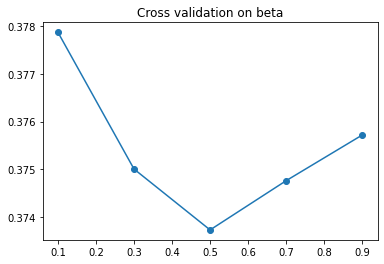

In [ ]:
plt.plot(b, mse_list, '-o')
plt.title('Cross validation on beta')

In [ ]:
def predict(a, f):
    u = a - 1
    if f not in y_train.columns:
        return mean[u]
    u_list = y_train.index[y_train.loc[:, f] != 0]
    ind = onp.argsort(cos_sim[u])[::-1]
    ind = ind[np.where(onp.isin(ind, u_list))][:5]
    num = y_train.loc[ind, f] - mean[ind]
    denom = cos_sim[u][ind]
    if np.sum(denom) == 0:
        return mean[u]
    num = num @ denom
    return mean[a] + num / np.sum(denom)

In [ ]:
y_pred = list(map(predict, X_test['User_ID'], X_test['id']))

In [ ]:
y_pred - test_df['Rating']

In [ ]:
mse = onp.sum(onp.square(y_pred - test_df['Rating'])) / len(y_pred)
np.sqrt(mse)

DeviceArray(1.01019432, dtype=float64)